# Module 2 Final Project Submission
### SQL EDA and Hypothesis Testing

Student name: Fernando Aguilar Islas<br>
Student pace: Part Time<br>
Scheduled project review date/time: TBA<br>
Instructor name: Brandon Lewis<br>
Blog post URL:<br>
Video Walkthrough URL:<br>

## 1. Introduction
For this project I will solve relevant questions utilizing hypothesis testing and statistical analysis using information from the Northwind Database. The tables contain company's information about operating regions, suppliers, employees, clients, orders, and products. Below is the Entity Relationship Diagram (ERD) of the database I will be working with.<br>
### Northwind's SQL Database

<img src='Northwind_ERD.png'>

## 2. Objective <br>

The priority is to find startegies that will increase Northiwind's profits, hence, I will be looking into solutions that either increase revenue or cut down costs. The following questions will be answered thoruought the notebook, each with its own section stating its null and alternate hypothesis, and carrying out statistical testing to verify the significance of the findings. This will enable me to provide Northwind with relevant recommendations in how to improve their operations to obtain a higher profit.<br>

1. **Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**
3. **Are certain employees more productive than others?**
4. **Do certain product categories have higher demand?**
5. **Another great question?**<br>

## 3. Methodology <br>
Throughout the project, in order to answer each of the stated questions, I will extract the necessary data from the SQL database and perform hypothesis testing. I will perform parametric and/or non-parametric testing to find wether or not we can reject the null hypothesis with a given significance level. Since parametric testing relies on the assumption that the sample data has a specific distribution (usually Gaussian), I will start by testing this assumption using the Shapiro–Wilk test. Then, based on the results I will proceed with hypothesis testing accordingly, state the confidence level (Type I error), and arrive to conclusions to provide statistically significant recommendations. This recommendations have the goal of increasing revenues, decresing costs or identify unique areas of opportunity to increase profits.<br>

Since the data is in an SLQ database I will start by loading all the necessary libraries to access, and retrieve the data into pandas dataframes for ease of manipulation. I will also load libraries to transform, and visualize data as well as the necessary tools to carry out EDA and hypothesis testing. After obtaining the necessary tools and establishing a connection to the database, I will go ahead and answer the first question.

In [1]:
#Import sql libraries to retrieve, manipulate and explore data from database.
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import sqlite3 as sql

#Import tools for Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np

#Import tools for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import tools for hypothesis testing
from scipy import stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

#Helper functions for presentation purposes
from ipywidgets import interact, interactive
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create engine, session and inspector to access and retrieve data in the database.
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)

2019-06-07 15:41:16,832 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-07 15:41:16,833 INFO sqlalchemy.engine.base.Engine ()
2019-06-07 15:41:16,833 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-07 15:41:16,834 INFO sqlalchemy.engine.base.Engine ()


In [3]:
'''Often times, actual table and column names differ to the ones in the ERD.
Hence, it is helpfull to get the table names form the actual database to
avoid errors during the retreival of data and EDA.'''
# Obtain and store the names of tables in database as as list.
db_tables=inspector.get_table_names()
db_tables

2019-06-07 15:41:16,839 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-07 15:41:16,840 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:
#Visualise first few lines of each table to get a sense of their contents.
for table in db_tables:
    df_sample = pd.read_sql_query(f"SELECT * FROM [{table}] Limit 5", engine)
    print('Table: ', table)
    print(df_sample,'\n')

2019-06-07 15:41:16,849 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Category] Limit 5
2019-06-07 15:41:16,850 INFO sqlalchemy.engine.base.Engine ()
Table:  Category
   Id    CategoryName                                        Description
0   1       Beverages        Soft drinks, coffees, teas, beers, and ales
1   2      Condiments  Sweet and savory sauces, relishes, spreads, an...
2   3     Confections                Desserts, candies, and sweet breads
3   4  Dairy Products                                            Cheeses
4   5  Grains/Cereals                Breads, crackers, pasta, and cereal 

2019-06-07 15:41:16,855 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Customer] Limit 5
2019-06-07 15:41:16,855 INFO sqlalchemy.engine.base.Engine ()
Table:  Customer
      Id                         CompanyName         ContactName  \
0  ALFKI                 Alfreds Futterkiste        Maria Anders   
1  ANATR  Ana Trujillo Emparedados y helados        Ana Trujillo   
2  ANTON      

2019-06-07 15:41:16,920 INFO sqlalchemy.engine.base.Engine ()
Table:  Region
   Id RegionDescription
0   1           Eastern
1   2           Western
2   3          Northern
3   4          Southern 

2019-06-07 15:41:16,926 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Shipper] Limit 5
2019-06-07 15:41:16,926 INFO sqlalchemy.engine.base.Engine ()
Table:  Shipper
   Id       CompanyName           Phone
0   1    Speedy Express  (503) 555-9831
1   2    United Package  (503) 555-3199
2   3  Federal Shipping  (503) 555-9931 

2019-06-07 15:41:16,930 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Supplier] Limit 5
2019-06-07 15:41:16,931 INFO sqlalchemy.engine.base.Engine ()
Table:  Supplier
   Id                         CompanyName                 ContactName  \
0   1                      Exotic Liquids            Charlotte Cooper   
1   2          New Orleans Cajun Delights               Shelley Burke   
2   3           Grandma Kelly's Homestead               Regina Murphy   
3   4  

### 3.1 Helper functions.

In [66]:
#Shapiro-Wilk test for normality
def sw_test (data):
    '''Null: Data is normally distributed
    Alternate: Data is not normally distributed.
    If p value < 0.05 then reject null.'''
    if stats.shapiro(data)[1]<.05:
        print('The sample is not normally distributed')
        return stats.shapiro(data)
    else:
        print('The sample is normally distributed')
        return stats.shapiro(data)

#Welch's t-test
def welch_t(a,b, equal_var=False,describe = True ):
    #Calculate degrees of freedom
    dof_num = (a.var()/a.size + b.var()/b.size)**2
    dof_den =(a.var()/a.size)**2 / (a.size-1) + (b.var()/b.size)**2 / (b.size-1)
    dof = dof_num/dof_den
    #Perform Welch's t-test
    test, p_val = stats.ttest_ind(a,b, equal_var = equal_var)
    if describe:
        print(f"Welch's t-test = {test}\np-value: {p_val}\nDoF: {dof}")
        #Print decision.
        if p_val<0.05:
            print('Decision: Reject the null hypothesis')
        else:
            print('Decision: Fail to reject the null hypothesis')
    return stats.ttest_ind(a,b, equal_var = False)

#Cohen's d Effect size
def cohen_d(a,b, describe = True):
    a_n,b_n = len(a),len(b)
    #Calculate pooled standard deviation.
    pv_num = ((a_n-1)*a.var())+((b_n-1)*b.var())
    pv_den = a_n+b_n
    pooled_sd = np.sqrt(pv_num/pv_den)
    d = (a.mean()-b.mean())/pooled_sd
    if describe:
        print("Cohens'd: ",d)
        if d<0.20:
            print('Effect Size: Very Small')
        elif d<0.50:
            print('Effect Size: Small')
        elif d<0.80:
            print('Effect Size: Medium')
        else:
            print('Effect Size: Large')
    return d

def plot_compare(a,b, title ='Quantities Ordered with and without discount',
                labela = 'Discount offered', labelb='No discount'):
    sns.distplot(a, label=labela, 
             color='blue', hist_kws=dict(alpha=.3))
    sns.distplot(b, label=labelb,
            color='orange', hist_kws=dict(alpha=.3))
    plt.axvline(df_orderd.Quantity.mean(), 0,1, color='blue', 
            linestyle='--', label='Mean Quantity')
    plt.axvline(df_ordernd.Quantity.mean(), 0,1, color='orange', 
            linestyle='--', label='Mean Quantity' )
    plt.title(title)
    plt.ylabel('frequency')
    plt.legend()
    plt.show();
    print('Average quantity ordered with discount: ',round(a.mean()))
    print('Average quantity ordered without discount: ',round(b.mean()))
    print('Percentage increase by offering discount: ',
          round((a.mean()-b.mean())/b.mean()*100, 2),'%')
    
def ANOVA(formula,data, decision=True):
    lm = ols(formula,data).fit()
    result = sm.stats.anova_lm(lm, typ=1)
    if decision:
        if result['PR(>F)'][0]>0.05:
            print('Fail to reject the Null Hypothesis')
        else:
            print('Reject the Null Hypothesis')
    return result

## 4.  Do discounts have a statistically significant effect on the number of products customers order?<br>
Discounts are very important in every business to drive sales. Hence, it is imperative to find out if discounts increase the quantities ordered in a statistically significant manner. The null and alternate hypothesis are:<br>

> $H_{0}:$ *Discounts do not have an effect on the number of products ordered.*$\mu_0 = \mu1 $ <br> 
> $H_{1}:$ *Discounts have an effect on the number of products ordered.* $\mu_0 \neq \mu1 $ <br>
> Significance Level: $\alpha = 0.05$ *Probability of a Type I error*<br>

To conduct this hypothesis testing I will retrieve the required data from the OrderDetail table wich cointains infrormaton about quantities ordered and the discounts offered. 

In [6]:
#Create dataframes with relevant data.
#Orders with discount
df_orderd = pd.read_sql_query("SELECT Quantity, Discount FROM [OrderDetail] WHERE Discount >0", engine)
#Orders without discount
df_ordernd = pd.read_sql_query("SELECT Quantity, Discount FROM [OrderDetail] WHERE Discount ==0", engine)
#Check for null values and correct datatype.
print(df_orderd.info(),)
print(df_ordernd.info(), '\n')
#Descriptive statistics.
print(df_orderd.describe())
print(df_ordernd.describe())
#Visualize first lines of dataframe.
df_orderd.head()

2019-06-07 15:41:16,975 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM [OrderDetail] WHERE Discount >0
2019-06-07 15:41:16,976 INFO sqlalchemy.engine.base.Engine ()
2019-06-07 15:41:16,984 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM [OrderDetail] WHERE Discount ==0
2019-06-07 15:41:16,985 INFO sqlalchemy.engine.base.Engine ()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
Quantity    838 non-null int64
Discount    838 non-null float64
dtypes: float64(1), int64(1)
memory usage: 13.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 2 columns):
Quantity    1317 non-null int64
Discount    1317 non-null float64
dtypes: float64(1), int64(1)
memory usage: 20.7 KB
None 

         Quantity    Discount
count  838.000000  838.000000
mean    27.109785    0.144439
std     20.771439    0.071808
min      1.000000    0.010000
25%     12.000000    0.1000

,Quantity,Discount
0,35,0.15
1,15,0.15
2,6,0.05
3,15,0.05
4,40,0.05


From this initial data exploration, I can confirm that the data is in the correct datatype as well that it conforms with common sense that there canot be a quantity ordered below 1 or discount below 0. Also, there a no missing values in the data. Northwind is currently offerinf discounts ranging form 1% to 25%. First I will start by visulizing the data.

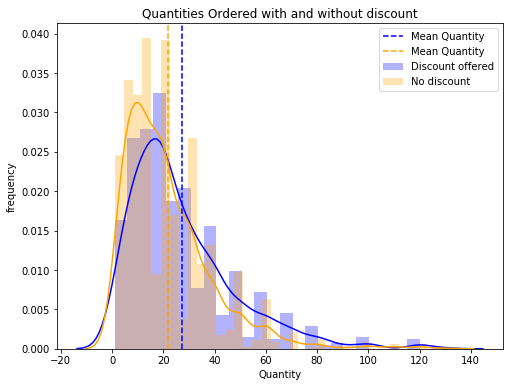

Average quantity ordered with discount:  27
Average quantity ordered without discount:  22
Percentage increase by offering discount:  24.84 %


In [7]:
fig = plt.figure(figsize=(8,6))
plot_compare(df_orderd.Quantity,df_ordernd.Quantity, title ='Quantities Ordered with and without discount',
                labela = 'Discount offered', labelb='No discount')

From the visualization, we get that quantities are indeed larger for orders with discounts than for orders without them. In order to test if this difference is significant, I will use a two sample t-test (difference in means) with a 5% significance level. This t-test assumes normality of our data, hence I will proceed to test this assumption with the Shapiro-Wilk test for normality.

In [8]:
#Test both samples for normality
sw_orderdQ =  sw_test(df_orderd.Quantity)
sw_orderndQ = sw_test(df_ordernd.Quantity)

The sample is not normally distributed
The sample is not normally distributed


Alhtough neither sample is normally distributed, I can still perform the t-test because the samples sizes are very large >800. Another assumption of the t-test is that the samples are from populations with equal variances. Hence I will proceed to test this assumption. I will perform Levene test for equal variances given that our samples are not normally distributed.

In [9]:
#Perfom Levene test on both samples.
if stats.levene(df_orderd.Quantity,df_ordernd.Quantity)[1]<0.05:
    print('Input samples are not from populations with equal variances.')
else:
    print('Input samples are from populations with equal variances.')

Input samples are not from populations with equal variances.


Now that I know input samples are not from populations with equal variances, I will be performing a Welch's t-test, to see if the two sample means are significantly different.

In [10]:
welch1 = welch_t(df_orderd.Quantity,df_ordernd.Quantity)
d = cohen_d(df_orderd.Quantity,df_ordernd.Quantity)

Welch's t-test = 6.239069142123973
p-value: 5.65641429030433e-10
DoF: 1561.7678231942134
Decision: Reject the null hypothesis
Cohens'd:  0.28641058366376687
Effect Size: Small


**Result:**
Given the test results we can successully reject the null hypothesis and accept the alternative that orders with discounts have higher average quantity ordered. Moreover, with cohen's d value, I conclude that the effect size of the discounts is small.

### 4.1  At what level(s) do discounts have a statistically significant effect on the number of products customers order?<br>
I have already accepted the alternate hypotheiss that discounts do increase the quantities ordered. Now, I will attemp to find what levels of discount are more efficient at driving up sales. Principally, I will be looking at the effect size of the discount level against orders with no discounts and orders with different discount level.

In [11]:
#Create array with discounts offered.
disc_levels = np.array(pd.Series.unique(df_orderd['Discount']).astype(float))
disc_levels.sort()
disc_levels

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1 , 0.15, 0.2 , 0.25])

In [12]:
disc_n={}
for d in disc_levels:
    '''Find out how many orders there are per level of discount.'''
    level_name = str(d*100)+' %'
    disc_n[level_name]=len(df_orderd[df_orderd['Discount']==d])

df_nlevels = pd.DataFrame.from_dict(disc_n, orient='index', columns=['Number of Orders'])
df_nlevels

,Number of Orders
1.0 %,1
2.0 %,2
3.0 %,3
4.0 %,1
5.0 %,185
6.0 %,1
10.0 %,173
15.0 %,157
20.0 %,161
25.0 %,154


I will only look at discount values of 5%, 10%, 15%, 20%, and 25%, because all other discounts have very few orders placed, I will consider them as outliers since for the most part they seem to be one-offs. 

In [13]:
#Create separate dataframes according to the different selected discounts.
selected_d = np.array([.05,.1,.15,.2,.25])#Array of selected discounts.
#List of dataframes for different discount levels.
dfs=[]
for d in selected_d:
    df_dl = df_orderd[df_orderd['Discount'] == d]
    dfs.append(df_dl)

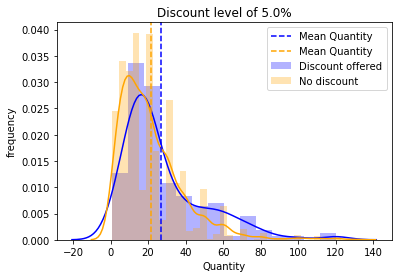

Average quantity ordered with discount:  28
Average quantity ordered without discount:  22
Percentage increase by offering discount:  28.99 %


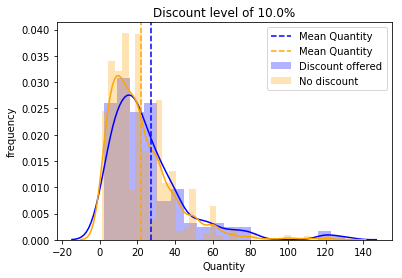

Average quantity ordered with discount:  25
Average quantity ordered without discount:  22
Percentage increase by offering discount:  16.22 %


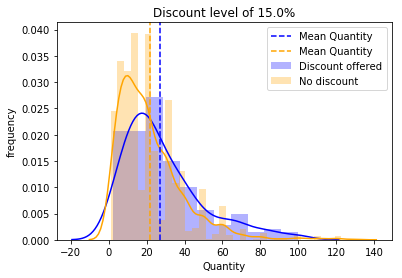

Average quantity ordered with discount:  28
Average quantity ordered without discount:  22
Percentage increase by offering discount:  30.7 %


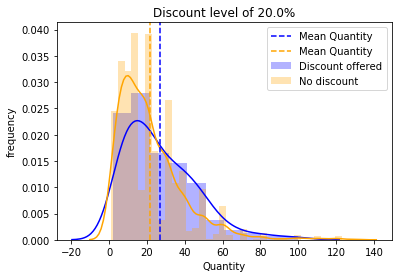

Average quantity ordered with discount:  27
Average quantity ordered without discount:  22
Percentage increase by offering discount:  24.45 %


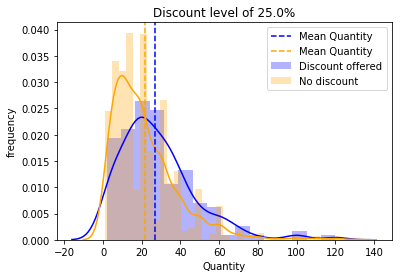

Average quantity ordered with discount:  28
Average quantity ordered without discount:  22
Percentage increase by offering discount:  30.05 %


In [14]:
'''Let's start by vizualising each of the discount levels order quantity 
distributions against orders with no discount.'''
for i in range(len(dfs)):
    plot_compare(dfs[i].Quantity, df_ordernd.Quantity,title=f'Discount level of {selected_d[i]*100}%')

Percentage increase in quantities ordered by discount level range from 16% to almost 31%. From the previous hypotheiss testing results, on average offering discounts have a small effect in increasing order quantities. For this test we should focus on the lowest discount level that provides the largest effect size, since this would be the optimal discount level at which revenues can be maximized.

In [15]:
#Get results for hypothesis testing.
results=[]
for i in range(len(dfs)):
    print(f'Hypothesis testing results for discount level of: {selected_d[i]*100}%')
    welch = welch_t(dfs[1].Quantity,df_ordernd.Quantity)
    d = cohen_d(dfs[i].Quantity,df_ordernd.Quantity)
    decision = 'Reject the Null' if welch[1]<0.05 else 'Fail to Reject the Null'
    result = [f'{selected_d[i]*100}%', decision, d]
    results.append(result)
    print('\n')
results_df=pd.DataFrame(results,columns=['Discount_Level', 'Decision', "Cohen_d"])
results_df.sort_values('Cohen_d')

Hypothesis testing results for discount level of: 5.0%
Welch's t-test = 2.094434281933477
p-value: 0.0374559661063408
DoF: 204.02596077508417
Decision: Reject the null hypothesis
Cohens'd:  0.3471571400334967
Effect Size: Small


Hypothesis testing results for discount level of: 10.0%
Welch's t-test = 2.094434281933477
p-value: 0.0374559661063408
DoF: 204.02596077508417
Decision: Reject the null hypothesis
Cohens'd:  0.1960959633346713
Effect Size: Very Small


Hypothesis testing results for discount level of: 15.0%
Welch's t-test = 2.094434281933477
p-value: 0.0374559661063408
DoF: 204.02596077508417
Decision: Reject the null hypothesis
Cohens'd:  0.37269784425960406
Effect Size: Small


Hypothesis testing results for discount level of: 20.0%
Welch's t-test = 2.094434281933477
p-value: 0.0374559661063408
DoF: 204.02596077508417
Decision: Reject the null hypothesis
Cohens'd:  0.30092823748975356
Effect Size: Small


Hypothesis testing results for discount level of: 25.0%
Welch's t-test

,Discount_Level,Decision,Cohen_d
1,10.0%,Reject the Null,0.196096
3,20.0%,Reject the Null,0.300928
0,5.0%,Reject the Null,0.347157
4,25.0%,Reject the Null,0.366873
2,15.0%,Reject the Null,0.372698


From the results, I find it surpiring to see that the effect size is not perfectly correlated to discount levels. I would have expected incremental effect sizes as discount levels increase. The least effect size was shown at the 10% discount levels, a 5% or even offering a 15% discount gives a much larger effect size so they can be thought of as much better alternatives to boost sales. However, I still have to test if the differences amongst discount levels are statistically significant to find out if one is better than the other.

In [16]:
#Get all the possible combinations between different discount levels.
combs = itertools.combinations(range(len(dfs)),2)
#Perform Welch t-test amongst discount levels.
ct_results = []
for comb in combs:
    welch = welch_t(dfs[comb[0]].Quantity,dfs[comb[1]].Quantity,describe=False)
    d = cohen_d(dfs[comb[0]].Quantity,dfs[comb[1]].Quantity,describe=False)
    decision = 'Reject the Null' if welch[1]<0.05 else 'Fail to Reject the Null'
    result = [f'{selected_d[comb[0]]*100}% vs. {selected_d[comb[1]]*100}%', decision, d]
    ct_results.append(result)
crosstest_df=pd.DataFrame(ct_results,columns=['Discount_Level', 'Decision', "Cohen_d"])
crosstest_df

,Discount_Level,Decision,Cohen_d
0,5.0% vs. 10.0%,Fail to Reject the Null,0.128127
1,5.0% vs. 15.0%,Fail to Reject the Null,-0.017230
2,5.0% vs. 20.0%,Fail to Reject the Null,0.047781
3,5.0% vs. 25.0%,Fail to Reject the Null,-0.010817
4,10.0% vs. 15.0%,Fail to Reject the Null,-0.149786
5,10.0% vs. 20.0%,Fail to Reject the Null,-0.089275
6,10.0% vs. 25.0%,Fail to Reject the Null,-0.145591
7,15.0% vs. 20.0%,Fail to Reject the Null,0.068449
8,15.0% vs. 25.0%,Fail to Reject the Null,0.006935
9,20.0% vs. 25.0%,Fail to Reject the Null,-0.062615


**Result:** There are no statistically significant differences in quantities ordered amongst discount levels. I failed to reject the null hypothesis, so I cannot accept the alternative that there is a statistically significant difference in means amongts dicount levels.

## 5. Are certain employees more productive than others? <br>
Northwind has 9 employees on its sales department, hence it is very important to see if there are any stars to encourage their performance, or identify poor performing employees to try and push them up to par. To find out if there are differences in quantities ordered I will use a One-Way ANOVA Hypotheiss Test. The null hypothesis for ANOVA is that the mean order quantity is the same for all employees. The alternative hypothesis is that the average is not the same for all employees.

<br>
> $H_{0}:$ *All employees have the same ordered quantities*$\mu_0 = \mu_1 = \mu_n $ <br> 
> $H_{1}:$ *Quantities ordered are not the same for all employees* $\mu_0 = \mu:1 \neq \mu_n $ <br>
> Significance Level: $\alpha = 0.05$ *Probability of a Type I error*<br>

I will gather quantities ordered information in a per country basis based on the employees location. The tables relevant to answering this question are: Employee, Order and Order Detail.

In [17]:
#Perform SQL query to get requiered data.
employee_orders = pd.read_sql_query("""SELECT e.Country, od.Quantity, e.ID AS eID
                                  FROM [Employee] AS e
                                  JOIN [Order] AS o ON e.ID==o.EmployeeID
                                  JOIN [OrderDetail] AS od ON o.ID == od.OrderID""", engine)
#Group dtaa by employee and get descriptive statistics
employee_orders.groupby('eID').Quantity.describe()

2019-06-07 15:41:18,844 INFO sqlalchemy.engine.base.Engine SELECT e.Country, od.Quantity, e.ID AS eID
                                  FROM [Employee] AS e
                                  JOIN [Order] AS o ON e.ID==o.EmployeeID
                                  JOIN [OrderDetail] AS od ON o.ID == od.OrderID
2019-06-07 15:41:18,845 INFO sqlalchemy.engine.base.Engine ()


,count,mean,std,min,25%,50%,75%,max
eID,,,,,,,,
1,345.0,22.643478,19.658357,1.0,10.0,20.0,30.0,120.0
2,241.0,25.124481,21.164068,1.0,10.0,20.0,30.0,120.0
3,321.0,24.461059,18.396651,2.0,10.0,20.0,30.0,110.0
4,420.0,23.328571,18.105542,1.0,10.0,20.0,30.0,130.0
5,117.0,25.948718,20.755907,2.0,12.0,20.0,35.0,120.0
6,168.0,20.994048,16.694686,2.0,10.0,18.0,28.5,130.0
7,176.0,26.443182,21.185093,1.0,10.0,20.0,35.0,120.0
8,260.0,22.742308,17.480462,2.0,10.0,20.0,30.0,100.0
9,107.0,24.953271,18.031096,1.0,12.0,20.0,35.0,110.0


From the descriptive statistics, I can observe that values amongst employees do not vary greatly. They all have a relatively large amount of orders (sample size) hence I will be able to perform the ANOVA test event if the distributions for each of the employees order quantity is not normal.

'Order Quantites seem very similar amongst employees'

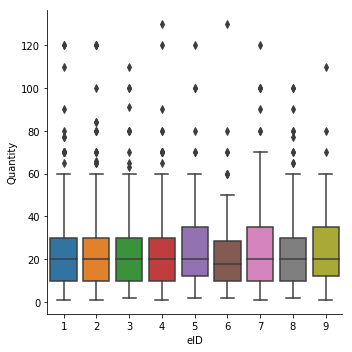

In [18]:
sns.catplot(x="eID", y="Quantity",kind="box",data=employee_orders, );
'''Order Quantites seem very similar amongst employees'''

In [72]:
formula = 'Quantity ~ C(eID)'
ANOVA(formula,employee_orders)

Fail to reject the Null Hypothesis


,df,sum_sq,mean_sq,F,PR(>F)
C(eID),8.0,4643.183282,580.39791,1.607646,0.11745
Residual,2146.0,774756.452913,361.02351,NaN,NaN


**Result:** Since I failed to reject the null, I will accept that the mean order quantity is the same for all employees. Hence, management is doing a great job so that every employee performs to the standard with no one left behind. Since employees included in thi stest were located in both locations, it is also safe to deduct that there are no differences in orders amongst countries.

## 6. Do certain product categories have higher demand?<br>
Another opportunity for investment might be to increase marketing budget to a product category that is expierencing a higer demand than the others. I wil start with the Null hypothesis that all product categories have the same amount of demand, and my alternate hypothesis is that at leats one category has a different demand than the others. For this I will also be performing a one-way ANOVA test.
<br>
> $H_{0}:$ *All employees have the same ordered quantities*$\mu_0 = \mu_1 = \mu_n $ <br> 
> $H_{1}:$ *Quantities ordered are not the same for all employees* $\mu_0 = \mu:1 \neq \mu_n $ <br>
> Significance Level: $\alpha = 0.05$ *Probability of a Type I error*<br>

I will need the order details per category, in specifict quantities ordered. 

In [49]:
#Create dataframe with categories, quantities ordered and country of the employee who submitted the order.
prod_region = pd.read_sql_query("""SELECT c.CategoryName AS Category, od.Quantity, e.Country
                                FROM [Order] AS o 
                                JOIN [OrderDetail] AS od ON o.ID == od.OrderID 
                                JOIN [Product] AS p ON od.ProductID == p.ID 
                                JOIN [Category] AS c ON p.CategoryID == c.ID
                                JOIN [Employee] AS e ON o.EmployeeID == e.ID""", engine)
prod_region.groupby(['Category']).describe()

2019-06-07 16:09:53,847 INFO sqlalchemy.engine.base.Engine SELECT c.CategoryName AS Category, od.Quantity, e.Country
                                FROM [Order] AS o 
                                JOIN [OrderDetail] AS od ON o.ID == od.OrderID 
                                JOIN [Product] AS p ON od.ProductID == p.ID 
                                JOIN [Category] AS c ON p.CategoryID == c.ID
                                JOIN [Employee] AS e ON o.EmployeeID == e.ID
2019-06-07 16:09:53,848 INFO sqlalchemy.engine.base.Engine ()


Quantity                                                     
                  count       mean        std  min   25%   50%    75%    max
Category                                                                    
Beverages         404.0  23.594059  19.222830  2.0  10.0  20.0  30.00  130.0
Condiments        216.0  24.527778  19.761818  1.0  10.0  20.0  30.00  120.0
Confections       334.0  23.670659  17.264570  1.0  10.0  20.0  34.25  120.0
Dairy Products    366.0  24.997268  18.797770  1.0  10.0  20.0  35.00  110.0
Grains/Cereals    196.0  23.275510  18.253924  2.0  10.0  20.0  30.00  130.0
Meat/Poultry      173.0  24.271676  22.238955  2.0  10.0  18.0  30.00  120.0
Produce           136.0  21.985294  18.490031  1.0  10.0  19.0  30.00  120.0
Seafood           330.0  23.275758  19.161917  1.0  10.0  20.0  30.00  120.0

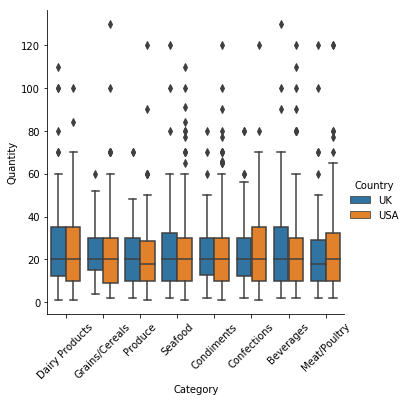

In [71]:
sns.catplot(x="Category", y="Quantity",kind="box", hue='Country',data=prod_region);
plt.setp(plt.xticks()[1], rotation=45);
plt.show()

In [68]:
'''It is worth noting that even when the plot is taking into account the employee's country
there are no apparent differences within categories and amongst categories.'''
formula = 'Quantity ~ C(Category)'
ANOVA(formula,prod_region)

Fail to reject the Null Hypothesis


,df,sum_sq,mean_sq,F,PR(>F)
C(Category),7.0,1292.377084,184.625298,0.509429,0.828058
Residual,2147.0,778107.259110,362.416050,NaN,NaN


## 8. Conclusion and Recommendations

## 9. Future Work

In [60]:
result

,df,sum_sq,mean_sq,F,PR(>F)
C(Country),1.0,23.189338,23.189338,0.06736,0.795618
Residual,134.0,46130.781250,344.259562,NaN,NaN


In [23]:
df_order = pd.read_sql_query("SELECT * FROM [order]", engine)

2019-06-07 15:41:19,780 INFO sqlalchemy.engine.base.Engine SELECT * FROM [order]
2019-06-07 15:41:19,782 INFO sqlalchemy.engine.base.Engine ()


In [24]:
df_order.ShipRegion.nunique()

9